## Using Pipeline for loan prediction

In most machine learning projects the data that you have to work with is unlikely to be in the ideal format for producing the best performing model. There are quite often a number of transformational steps such as encoding categorical variables, feature scaling and normalisation that need to be performed. Scikit-learn has built in functions for most of these commonly used transformations in it’s `preprocessing` package.

However, in a typical machine learning workflow you will need to apply all these transformations at least twice. Once when training the model and again on any new data you want to predict on. Of course you could write a function to apply them and reuse that but you would still need to run this first and then call the model separately. Scikit-learn pipelines are a tool to simplify this process. They have several key benefits:
- They make your workflow much easier to read and understand.
- They enforce the implementation and order of steps in your project.
- These in turn make your work much more reproducible.

In [1]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.drop('Loan_ID', axis=1) ## this will not be needed in training or prediction
train.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [3]:
train.head()
print(train.shape)
X = train.drop('Loan_Status', axis=1)
y = train['Loan_Status']

(614, 12)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Transformers

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,Imputer

There are both categorical and numeric variables so as a minimum it is needed to apply a one hot encoding transformation and some sort of scaler. We use a scikit-learn pipeline to perform those transformations, and at the same time apply the fit method.

In [6]:
train.dtypes ## or train.info()

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [7]:
## exploring missing data 
train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

The first step in building the `pipeline` is to define each transformer type. The convention here is generally to create transformers for the different variable types. In the code below we have created a numeric transformer which applies a `StandardScaler`, and includes a `SimpleImputer` to fill in any missing values. This is a really nice function in scikit-learn and has a number of options for filling missing values. We have chosen to use median but another method may result in better performance. The categorical transformer also has a `SimpleImputer` with a different fill method, and leverages `OneHotEncoder` to transform the categorical values into integers.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [9]:
## strategy: mean, median or most_frequent.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

Next we use the `ColumnTransformer` to apply the transformations to the correct columns in the dataframe. Before building this we have stored lists of the numeric and categorical columns using the pandas dtype method.

In [10]:
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train.select_dtypes(include=['object']).drop(['Loan_Status'], axis=1).columns

In [11]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Fitting the classifier

The next step is to create a pipeline that combines the preprocessor created above with a classifier. In this case I have used a simple RandomForestClassifier to start with.

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=100))])
                        #without n_estimators=100 it gives warning

You can then simply call the fit method on the raw data and the preprocessing steps will be applied followed by training the classifier.

In [16]:
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

To predict on new data it is as simple as calling the predict method and the preprocessing steps will be applied followed by the prediction.

In [35]:
y_pred = rf.predict(X_test)

### Model selection

A pipeline can also be used during the model selection process. The following example code loops through a number of scikit-learn classifiers applying the transformations and training the model.

In [19]:
from sklearn.metrics import confusion_matrix,accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [18]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


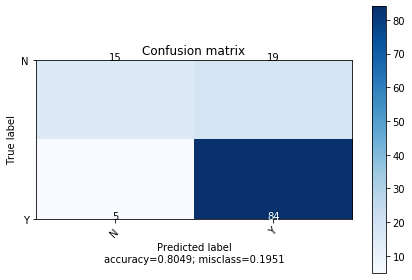



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


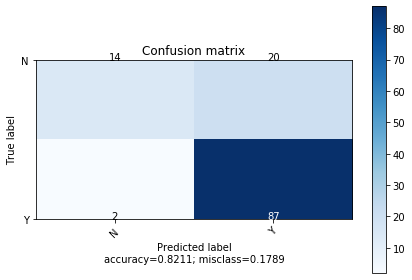



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


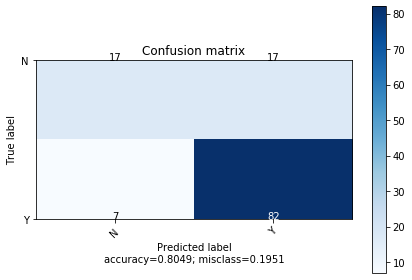



SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


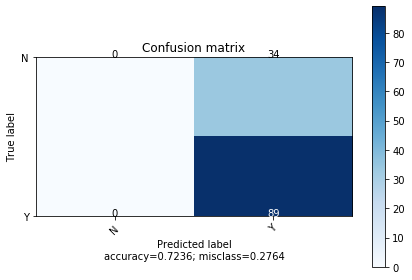



MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


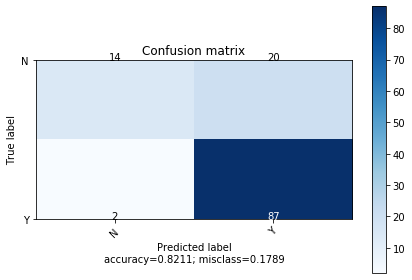



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


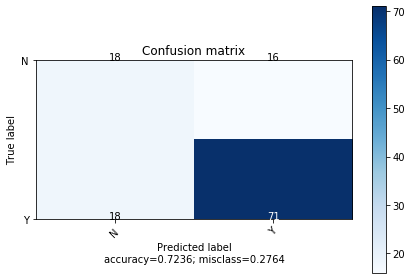

In [26]:
classifiers = [
    RandomForestClassifier(n_estimators=100),
    LogisticRegression(solver='lbfgs'), # without solver='lbfgs' it gives warning
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, gamma="auto",probability=True),
    MLPClassifier(activation='logistic',max_iter=1000),
    DecisionTreeClassifier()
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    #print(confusion_matrix(y_test, pipe.predict(X_test)))
    plot_confusion_matrix(confusion_matrix(y_test, pipe.predict(X_test)),normalize= False, target_names=y_train.unique().tolist())
    #print("model score: %.3f" % pipe.score(X_test, y_test))
    print("\n")